# Influences et généalogies

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itables import init_notebook_mode, show
import numpy as np
import scipy.stats as stats
import plotly.express as px


In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import sys

### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf


In [3]:

from netgraph import Graph, InteractiveGraph
from pyvis.network import Network


## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://ag15yee0az6rmk64.allegrograph.cloud/repositories/ceos"

In [5]:
query = """
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>


    SELECT ?s ?sLabel (MIN(?sBirth) as ?sBirthYear) ?o ?oLabel (MIN(?oBirth) as ?oBirthYear)
    WHERE {
        GRAPH <https://github.com/Laillaa/French_CEOs/blob/main/graphs/Wikidata-imported-data.md>
            {
                ?s  wdt:P185 ?o;
                    rdfs:label ?sLabel;
                    wdt:P569 ?sBirth.
                ?o  rdfs:label ?oLabel;
                    wdt:P569 ?oBirth.
            }
            }
    GROUP BY ?s ?sLabel ?o ?oLabel
"""

In [8]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)
print(qr)

{'head': {'vars': ['s', 'sLabel', 'sBirthYear', 'o', 'oLabel', 'oBirthYear']}, 'results': {'bindings': []}}


In [7]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

0


[]

In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['sUri', 'sLabel', 'sBirthYear', 'oUri', 'oLabel', 'oBirthYear']
df_p.head()

ValueError: Length mismatch: Expected axis has 0 elements, new values have 6 elements

In [ ]:
## Explorer les données importées
# Configuration:  https://github.com/mwouts/itables/blob/main/docs/advanced_parameters.md
show(df_p.sort_values(by='sBirthYear'), classes="display", scrollY="200px", scrollCollapse=True, paging=False, column_filters="footer", dom="lrtip")

#### Doublons

Y a-t-il des doublons ? Notamment produits par la transormation 

* Non

In [ ]:
### Regrouper et compter
sdf = df_p.groupby(by=['sUri','oUri']).size()
print(len(sdf))

3773


In [ ]:
### Nombre de doublons
print(len(sdf.values[sdf.values > 1]))
sdf = pd.DataFrame(sdf)
sdf.columns=['effectif']
### Réindexer et inspecter
sdf = sdf.reset_index(); sdf.sort_values(by='effectif', ascending=False).head()

0


sUri  \
3772    http://www.wikidata.org/entity/Q88155   
0     http://www.wikidata.org/entity/Q1000193   
1     http://www.wikidata.org/entity/Q1000934   
2     http://www.wikidata.org/entity/Q1000934   
3     http://www.wikidata.org/entity/Q1002250   

                                           oUri  effectif  
3772  http://www.wikidata.org/entity/Q102707780         1  
0      http://www.wikidata.org/entity/Q20250073         1  
1       http://www.wikidata.org/entity/Q1432117         1  
2         http://www.wikidata.org/entity/Q46120         1  
3      http://www.wikidata.org/entity/Q19609632         1

In [ ]:
### Compter les relations par personne, position source 
person_s = pd.DataFrame(df_p.groupby(by=['sUri', 'sLabel']).size())
person_s.columns = ['effectif_out']
person_s.reset_index(inplace=True)
person_s.sort_values(by='effectif_out', ascending=False).head(10)

sUri                  sLabel  \
1863   http://www.wikidata.org/entity/Q77078       Arnold Sommerfeld   
1854   http://www.wikidata.org/entity/Q76683          Ludwig Prandtl   
642   http://www.wikidata.org/entity/Q186465        Julian Schwinger   
936    http://www.wikidata.org/entity/Q28189             Abdus Salam   
308   http://www.wikidata.org/entity/Q132537      Robert Oppenheimer   
258   http://www.wikidata.org/entity/Q124236           Paul Scherrer   
738   http://www.wikidata.org/entity/Q202631  John Archibald Wheeler   
1351   http://www.wikidata.org/entity/Q47285           J. J. Thomson   
1032  http://www.wikidata.org/entity/Q323320           Kip S. Thorne   
939   http://www.wikidata.org/entity/Q284336        Dennis W. Sciama   

      effectif_out  
1863            28  
1854            20  
642             19  
936             19  
308             16  
258             15  
738             14  
1351            14  
1032            14  
939             13

In [ ]:
### Compter les relations par personne, position cible 
person_t = pd.DataFrame(df_p.groupby(by=['oUri', 'oLabel']).size())
person_t.columns = ['effectif_in']
person_t.reset_index(inplace=True)
person_t.sort_values(by='effectif_in', ascending=False).head(10)

oUri              oLabel  \
1662    http://www.wikidata.org/entity/Q295099   Ejnar Hertzsprung   
1104    http://www.wikidata.org/entity/Q183397          Fred Hoyle   
1586  http://www.wikidata.org/entity/Q27478306  Kenneth Le Couteur   
586    http://www.wikidata.org/entity/Q1287944       Maurice Pryce   
1618    http://www.wikidata.org/entity/Q284336    Dennis W. Sciama   
1508     http://www.wikidata.org/entity/Q25320       Paul Langevin   
3452  http://www.wikidata.org/entity/Q97630190      Warren B. Mori   
734    http://www.wikidata.org/entity/Q1483261      Klaus Zweiling   
1741    http://www.wikidata.org/entity/Q323260       Loránd Eötvös   
926     http://www.wikidata.org/entity/Q164389    Vilhelm Bjerknes   

      effectif_in  
1662            3  
1104            3  
1586            3  
586             3  
1618            3  
1508            3  
3452            3  
734             3  
1741            3  
926             3

In [ ]:
### Joindre les deux tableaux
person = person_s.merge(person_t, left_on='sUri', right_on='oUri')[['sUri','sLabel','effectif_in','effectif_out']]
person.columns = ['uri','label','effectif_in','effectif_out']
person.sort_values(by='effectif_out', ascending=False).head()


uri               label  effectif_in  \
942   http://www.wikidata.org/entity/Q76683      Ludwig Prandtl            1   
338  http://www.wikidata.org/entity/Q186465    Julian Schwinger            1   
488   http://www.wikidata.org/entity/Q28189         Abdus Salam            2   
148  http://www.wikidata.org/entity/Q132537  Robert Oppenheimer            1   
124  http://www.wikidata.org/entity/Q124236       Paul Scherrer            1   

     effectif_out  
942            20  
338            19  
488            19  
148            16  
124            15

In [ ]:
print(f"Nombre de personnes: {len(person)} \n", person.sort_values(by='effectif_out', ascending=False).head(10))

Nombre de personnes: 998 
                                           uri                   label  \
942     http://www.wikidata.org/entity/Q76683          Ludwig Prandtl   
338    http://www.wikidata.org/entity/Q186465        Julian Schwinger   
488     http://www.wikidata.org/entity/Q28189             Abdus Salam   
148    http://www.wikidata.org/entity/Q132537      Robert Oppenheimer   
124    http://www.wikidata.org/entity/Q124236           Paul Scherrer   
530    http://www.wikidata.org/entity/Q323320           Kip S. Thorne   
385    http://www.wikidata.org/entity/Q202631  John Archibald Wheeler   
680     http://www.wikidata.org/entity/Q47285           J. J. Thomson   
784     http://www.wikidata.org/entity/Q58978                Max Born   
366  http://www.wikidata.org/entity/Q19311699       Wilhelm Scheibner   

     effectif_in  effectif_out  
942            1            20  
338            1            19  
488            2            19  
148            1            16  
124 

In [ ]:
def plot_densites (data_frame, rows, cols):
    ## https://engineeringfordatascience.com/posts/matplotlib_subplots/
    plt.figure(figsize=(18, 4))
    plt.subplots_adjust(wspace=0.5)
    plt.suptitle("Distributions et densités", fontsize=18, y=1)

    e=data_frame.columns

    # loop through the length of tickers and keep track of index
    for n, e in enumerate(e):
        
        #plt.figure(figsize=(10,4))
        # add a new subplot iteratively
        ax = plt.subplot(rows, cols, n + 1)

        # filter df and plot ticker on the new subplot axis
        vals = data_frame[e]
        plt.hist(vals, density=True)
        ax = vals.plot.kde()
        ax.set_xlim(min(vals),max(vals))

        ### Test de Shapiro-Wilk: hypothèse H0 = distribution normale    
        sa = round(stats.shapiro(vals).pvalue, 4)
        psa = (f"Test Shapiro-Wilk,pvalue: {sa}, on accepte l'H0: distribution normale" if sa > 0.049 \
               else f"pvalue: {sa},Test de Shapiro-Wilk on peut rejeter l'H0: distrib. non normale")

        plt.xlabel(psa, fontsize=10)

        ax.set_title(f'Variable: {e}', fontsize=12)


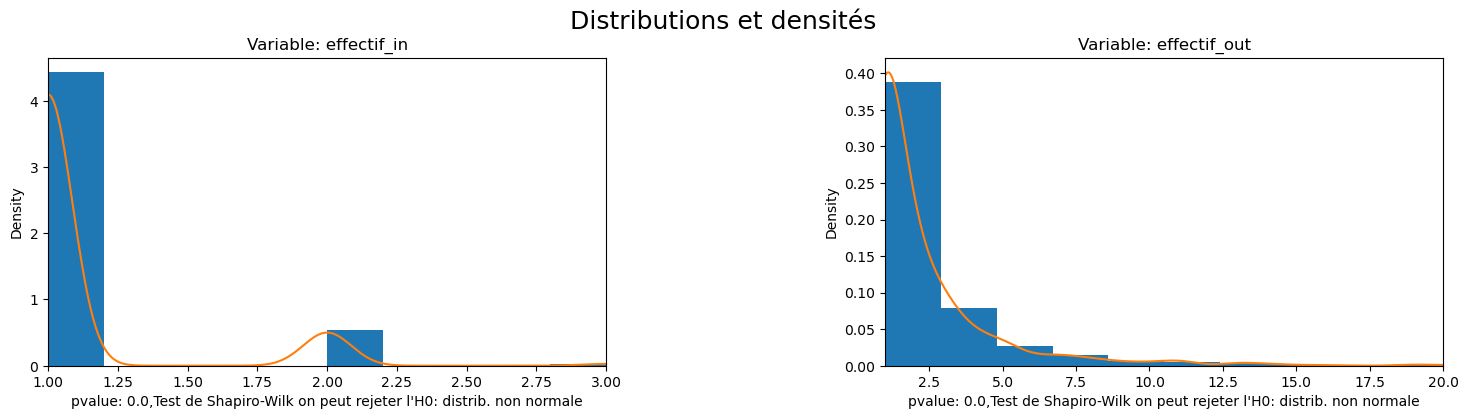

In [ ]:
dataframe = person[['effectif_in','effectif_out']]
plot_densites(dataframe, 1,2)

In [ ]:
ppg = pd.DataFrame(person.groupby(by=['effectif_out', 'effectif_in'])['label'].agg(','.join))
ppg.columns=['persons']
ppg.reset_index(inplace=True)
ppg.head()

effectif_out  effectif_in  \
0             1            1   
1             1            2   
2             1            3   
3             2            1   
4             2            2   

                                             persons  
0  Duncan Haldane,Bertrand Eynard,Richard Nelson ...  
1  Herbert Spohn,Ralph Neuhäuser,Robert Hugh Sand...  
2                                 Kenneth Le Couteur  
3  Charles Christian Lauritsen,F. Alexander Bais,...  
4  Paul Harzer,Konrad Osterwalder,William Lawrenc...

In [ ]:
### Affichage interactif
pp = ppg

## Nuage de points avec droite de régression
# https://www.kite.com/python/answers/how-to-plot-a-linear-regression-line-on-a-scatter-plot-in-python

#fig = plt.figure(figsize=(20,20))
x = pp['effectif_in']
y = pp['effectif_out']
l = pp['persons']



fig = px.scatter(pp, x="effectif_in", y="effectif_out", hover_data=[l])

fig.show()


In [ ]:
### https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
### Le coefficient de Spearman et la valeur de p 
# montrent qu'on ne peut pas rejeter l'H0 d'independance 
# et qu'il n'y a pas de correlation de rang 
# entre être influencé et influencer
res = stats.spearmanr(person[['effectif_in', 'effectif_out']])
print(res.statistic, "{:.10f}".format(float(res.pvalue)))


0.05732404377290113 0.0702723925


### Créer un réseau

In [ ]:
print(type(sdf), sdf.head())

<class 'pandas.core.series.Series'> sUri                                       oUri                                    
http://www.wikidata.org/entity/Q1000193    http://www.wikidata.org/entity/Q20250073    1
http://www.wikidata.org/entity/Q1000934    http://www.wikidata.org/entity/Q1432117     1
                                           http://www.wikidata.org/entity/Q46120       1
http://www.wikidata.org/entity/Q1002250    http://www.wikidata.org/entity/Q19609632    1
http://www.wikidata.org/entity/Q100590682  http://www.wikidata.org/entity/Q26201841    1
dtype: int64


In [ ]:
lsdf = sdf.index.to_list()
lsdf[:3]

[('http://www.wikidata.org/entity/Q1000193',
  'http://www.wikidata.org/entity/Q20250073'),
 ('http://www.wikidata.org/entity/Q1000934',
  'http://www.wikidata.org/entity/Q1432117'),
 ('http://www.wikidata.org/entity/Q1000934',
  'http://www.wikidata.org/entity/Q46120')]

In [ ]:
###
# https://networkx.org/documentation/stable/reference/generated/networkx.convert.from_edgelist.html
G = nx.from_edgelist(lsdf, create_using=nx.DiGraph)

In [ ]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G)
print(G.is_multigraph(), G.is_directed(), G.number_of_nodes(), G.number_of_edges(), nx.density(G))

False True 4458 3773 0.0001898908799330988


In [ ]:
len(nx.strongly_connected_components(G))

TypeError: object of type 'generator' has no len()

In [ ]:
largest = max(nx.strongly_connected_components(G), key=len)
print(type(largest))
print(len(list(largest)))

<class 'set'>
1


In [ ]:
largest = max(nx.weakly_connected_components(G), key=len)
print(type(largest))
print(len(list(largest)))

<class 'set'>
2057


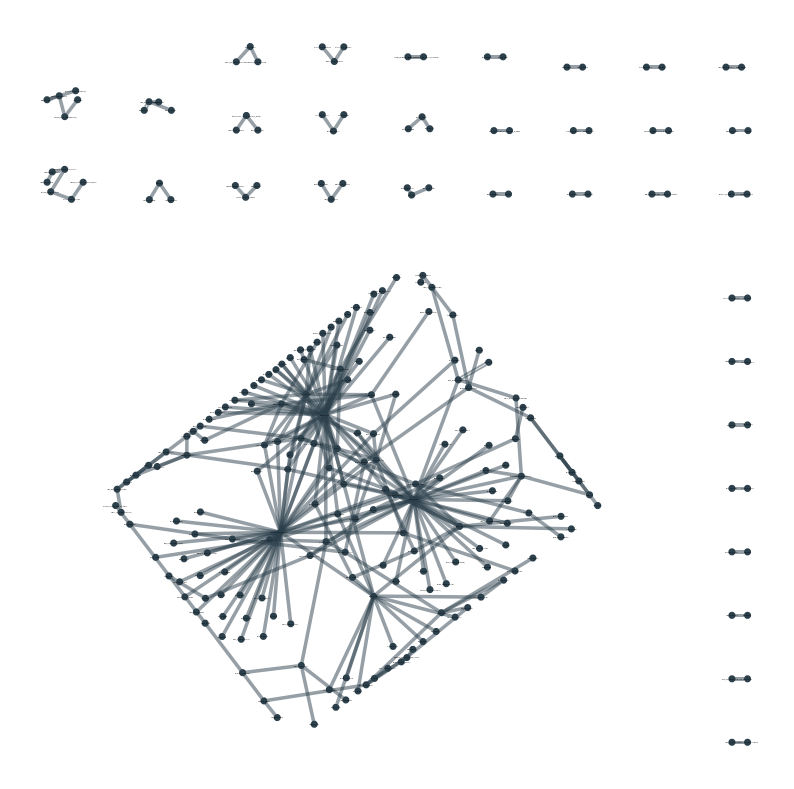

In [ ]:
### Noter les composantes indépendantes
# il y a des erreur numpy ! cachés avec la commande suivante
# mais elles empèchent un affichage correct
np.seterr(invalid='ignore')

fig = plt.figure(figsize=(10,10))
plot_instance = Graph(G,  node_color='red', node_size=0.5, node_labels=True, edge_width=0.5)


plt.show()

In [ ]:
### Lister les sommets de l'objet graphe ci-dessus
nl = [{i:i} for i in plot_instance.nodes]; type(nl), nl[:3]

(list,
 [{'Abraham_Gotthelf_Kästner': 'Abraham_Gotthelf_Kästner'},
  {'Johann_Christian_Martin_Bartels': 'Johann_Christian_Martin_Bartels'},
  {'Adrien-Marie_Legendre': 'Adrien-Marie_Legendre'}])

### Détecter les composantes du graphe

In [ ]:
wcc = nx.weakly_connected_components(G)

In [ ]:
lcc = [[list(c), len(c)] for c in wcc]; len(lcc), lcc[0]

(816,
 [['http://www.wikidata.org/entity/Q1000193',
   'http://www.wikidata.org/entity/Q20250073'],
  2])

### Créer le sous-graphe en utilisant la composante plus grande


A FAIRE Inspecter les sous-graphes en fonction des occupations ou du nombre de doctoratns, ou du pays comme propriétés des sommets


In [ ]:
## La composante de dimension maximale
max_l = [i[0] for i in lcc if i[1] == max([i[1] for i in lcc])][0]; max_l[:3]

['Joseph_Banks', 'Henri_Bergson', 'James_Ivory_(mathematician)']

In [ ]:
SG = G.subgraph(largest)

In [ ]:
SG.is_multigraph(), nx.is_strongly_connected(SG), SG.is_directed(), SG.number_of_nodes(), SG.number_of_edges(), nx.density(SG)

(False, False, True, 2057, 2173, 0.0005138097300855577)

In [ ]:
### Détecter les relations cycliques
cb = nx.recursive_simple_cycles(SG) ; len(cb)

1

In [ ]:
### https://networkx.org/nx-guides/content/algorithms/dag/index.html
try:
    print(nx.find_cycle(SG))
except Exception as e:
    print(e)

[('Henry_Briggs_(mathematician)', 'John_Napier'), ('John_Napier', 'Henry_Briggs_(mathematician)')]


#### Vérification manuelle

Vérifier quelle relation il faut supprimer

In [ ]:
a = G.edges(['John_Napier', 'Henry_Briggs_(mathematician)']); a

OutEdgeDataView([('John_Napier', 'Henry_Briggs_(mathematician)'), ('Henry_Briggs_(mathematician)', 'Isaac_Newton'), ('Henry_Briggs_(mathematician)', 'James_Gregory_(mathematician)'), ('Henry_Briggs_(mathematician)', 'John_Napier'), ('Henry_Briggs_(mathematician)', 'John_Pell_(mathematician)')])

In [ ]:
G.get_edge_data('John_Napier', 'Henry_Briggs_(mathematician)', default=None)

{'relationship': 'influenced'}

In [ ]:
### Supprimer la relation
G.remove_edge('John_Napier', 'Henry_Briggs_(mathematician)')

In [ ]:
### https://networkx.org/nx-guides/content/algorithms/dag/index.html
try:
    print(nx.find_cycle(SG))
except Exception as e:
    print(e)

No cycle found.


### Centralité de degré

Documentation: [degree_centrality(G)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)

In [ ]:
### Noter le résultat de la fonction
print([d for d in nx.degree(SG)][:3])
print('----')
### l'ajout d'une propriété doit se faire sous la forme de dictionnaire
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(SG)])
#print(degree)

[('Adrien-Marie_Legendre', 1), ('Évariste_Galois', 2), ('Anne_Conway_(philosopher)', 1)]
----


In [ ]:
nx.set_node_attributes(SG, degree)
print(list(SG.nodes.data())[:3])

[('Adrien-Marie_Legendre', {'degree': 1}), ('Évariste_Galois', {'degree': 2}), ('Anne_Conway_(philosopher)', {'degree': 1})]


In [ ]:
sb = sorted(list(nx.degree(SG)), key=lambda x: x[1], reverse=True)
sb[:5]

[('René_Descartes', 41),
 ('Gottfried_Wilhelm_Leibniz', 37),
 ('Isaac_Newton', 36),
 ('Pierre_Gassendi', 16),
 ('Blaise_Pascal', 14)]

In [ ]:
print(len(person), person.sort_values(by='effectif_out', ascending=False).head(7))

55                            person  effectif_out  effectif_in
17      Gottfried_Wilhelm_Leibniz            29            8
19                   Isaac_Newton            28            9
46                 René_Descartes            22           19
43                Pierre_Gassendi            11            5
2                   Blaise_Pascal             8            6
37                 Leonhard_Euler             5            3
6   David_Gregory_(mathematician)             4            2


In [ ]:
## Proportions dans ce cas, non effectifs
sorted(nx.out_degree_centrality(SG).items(), key=lambda kv: kv[1], reverse=True)[:5]

[('Gottfried_Wilhelm_Leibniz', 0.16477272727272727),
 ('Isaac_Newton', 0.1534090909090909),
 ('René_Descartes', 0.125),
 ('Pierre_Gassendi', 0.0625),
 ('Blaise_Pascal', 0.045454545454545456)]

### Centralité d'influence ou de pouvoir (_eigenvector_)

[Eigenvector centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html#networkx.algorithms.centrality.eigenvector_centrality)

"For directed graphs this is “left” eigenvector centrality which corresponds to the __in-edges__ in the graph. For __out-edges__ eigenvector centrality __first reverse__ the graph with G.reverse()."

_On inverse donc pour calculer le pouvoir à droite_, c'est-à-dire dans les arcs sortants, et donc vers la __déscendance__


In [ ]:
### https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality_numpy.html
eigenvector = nx.eigenvector_centrality_numpy(SG.reverse())

In [ ]:
l = sorted((v, f"{c:0.2f}") for v, c in eigenvector.items())
l[:3]

[('Abraham_Sharp', '-0.00'),
 ('Abraham_de_Moivre', '-0.00'),
 ('Adrien-Marie_Legendre', '0.00')]

In [ ]:
nx.set_node_attributes(SG, eigenvector, 'eigenvector')
print(list(SG.nodes.data())[:3])

[('Adrien-Marie_Legendre', {'degree': 1, 'eigenvector': 2.1928007626693484e-16}), ('Évariste_Galois', {'degree': 2, 'eigenvector': 4.444092967190851e-19}), ('Anne_Conway_(philosopher)', {'degree': 1, 'eigenvector': 3.2274346352832955e-07})]


### Centralité d'intermédiarité

[Betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

In [ ]:
#print(nx.betweenness_centrality(G))
betweenness = nx.betweenness_centrality(SG)

In [ ]:
sb = sorted(betweenness.items(), key=lambda x: x[1])
sb[:5]

[('Adrien-Marie_Legendre', 0.0),
 ('Évariste_Galois', 0.0),
 ('Anne_Conway_(philosopher)', 0.0),
 ('Anselm_of_Canterbury', 0.0),
 ('Aristotle', 0.0)]

In [ ]:
sb_df = pd.DataFrame(sb)
sb_df.columns = ['person','betweenness']
sb_df.sort_values(by='betweenness', ascending=False)

person  betweenness
176             René_Descartes     0.050851
175               Isaac_Newton     0.029416
174  Gottfried_Wilhelm_Leibniz     0.028096
173              Blaise_Pascal     0.011988
172         Christiaan_Huygens     0.006867
..                         ...          ...
61                    Voltaire     0.000000
62        Walter_Rauschenbusch     0.000000
63               Wilhelm_Wundt     0.000000
64          Émilie_du_Châtelet     0.000000
88         Anders_Johan_Lexell     0.000000

[177 rows x 2 columns]

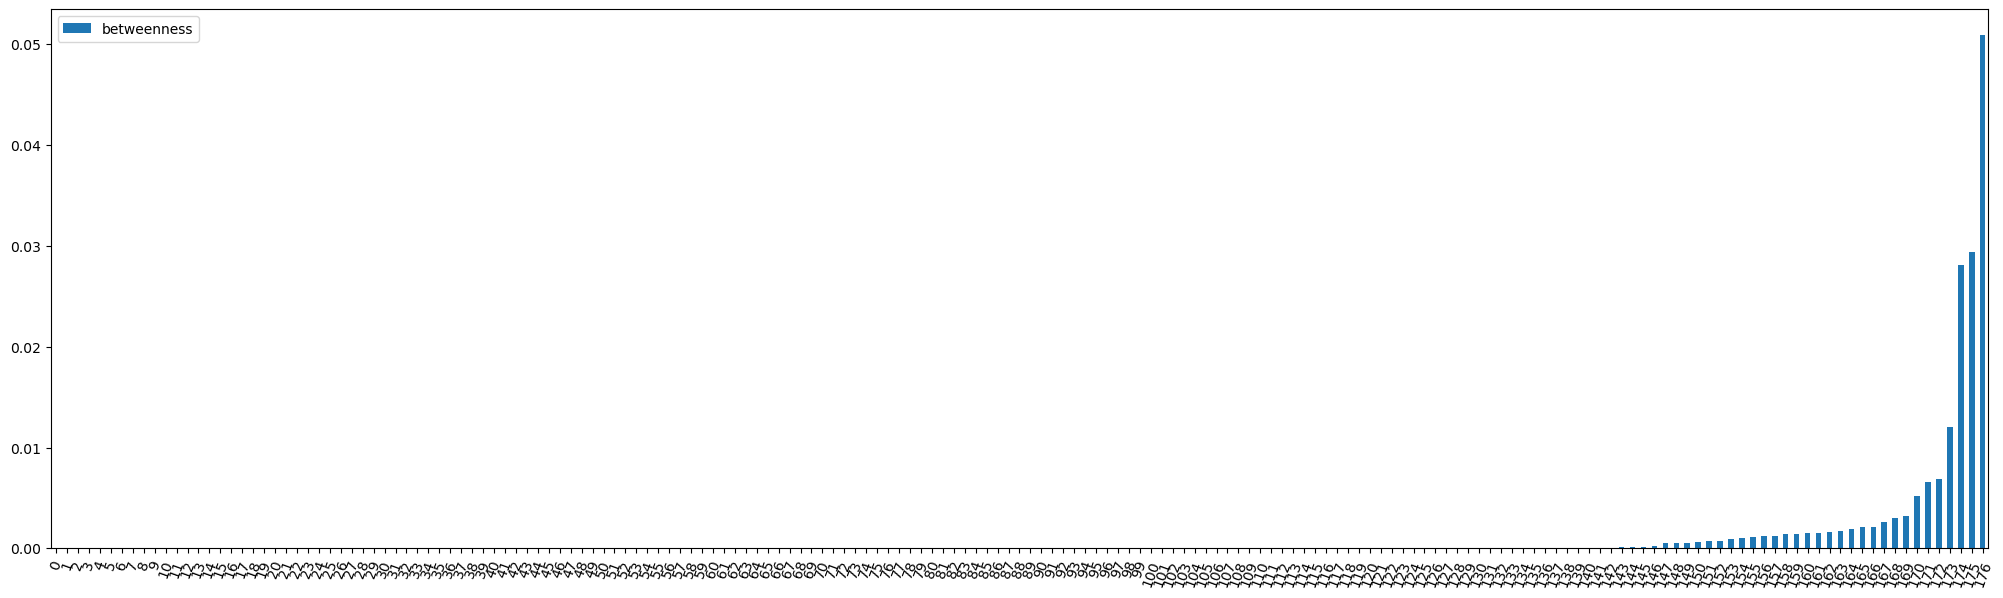

In [ ]:
### Cette visualisation donne une impression de la dispersion
x = sb_df.plot.bar(y='betweenness', rot=70, figsize=(25,7))

<Axes: >

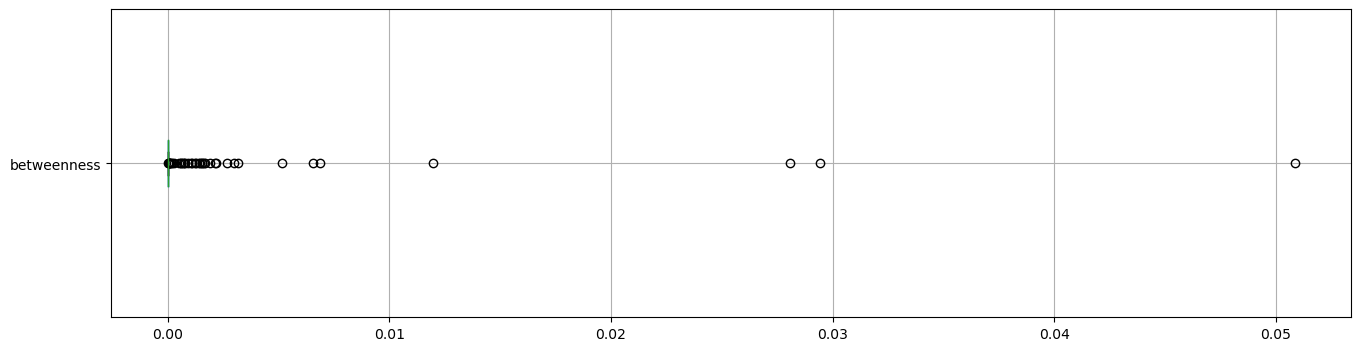

In [ ]:
sb_df.boxplot(column=['betweenness'], vert=False, figsize=(16,4))

<Axes: >

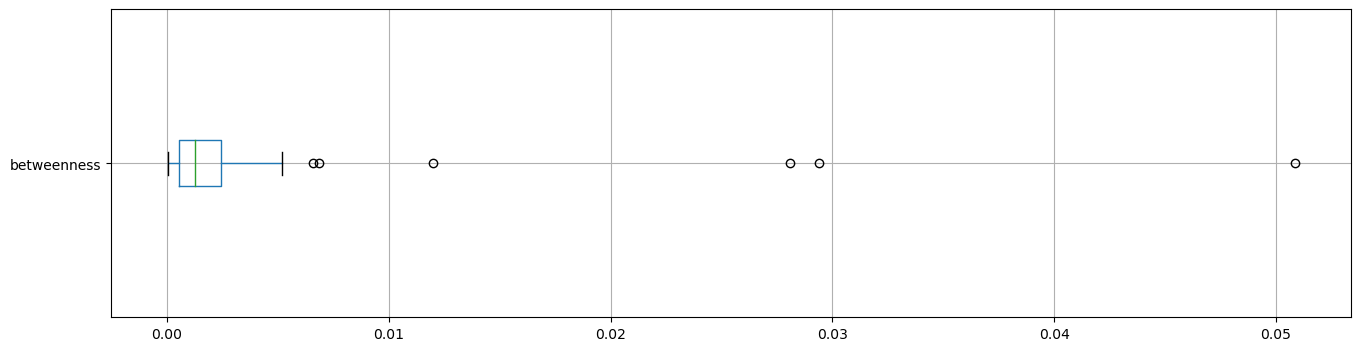

In [ ]:
sb_df[sb_df['betweenness'] != 0].boxplot(column=['betweenness'], vert=False, figsize=(16,4))

In [ ]:
nx.set_node_attributes(SG, betweenness, 'betweenness')
print(list(SG.nodes.data())[:3])

[('Adrien-Marie_Legendre', {'degree': 1, 'eigenvector': 2.1928007626693484e-16, 'betweenness': 0.0}), ('Évariste_Galois', {'degree': 2, 'eigenvector': 4.444092967190851e-19, 'betweenness': 0.0}), ('Anne_Conway_(philosopher)', {'degree': 1, 'eigenvector': 3.2274346352832955e-07, 'betweenness': 0.0})]


https://networkx.org/documentation/stable/auto_examples/graph/plot_dag_layout.html

In [ ]:
### Calculer des 'générations', les premiers parents, puis leurs enfants, etc.
for layer, nodes in enumerate(nx.topological_generations(SG)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        SG.nodes[node]["layer"] = layer

In [ ]:
list(SG.nodes.data())[:5]

[('Adrien-Marie_Legendre',
  {'degree': 1,
   'eigenvector': 2.1928007626693484e-16,
   'betweenness': 0.0,
   'layer': 0}),
 ('Évariste_Galois',
  {'degree': 2,
   'eigenvector': 4.444092967190851e-19,
   'betweenness': 0.0,
   'layer': 10}),
 ('Anne_Conway_(philosopher)',
  {'degree': 1,
   'eigenvector': 3.2274346352832955e-07,
   'betweenness': 0.0,
   'layer': 0}),
 ('Gottfried_Wilhelm_Leibniz',
  {'degree': 37,
   'eigenvector': 3.694410877673698e-09,
   'betweenness': 0.028095779220779216,
   'layer': 5}),
 ('Anselm_of_Canterbury',
  {'degree': 1,
   'eigenvector': 0.0025071390539761224,
   'betweenness': 0.0,
   'layer': 0})]

In [ ]:
### Cf. Nooy, Wouter de, Andrej Mrvar, and Vladimir Batagelj,
# Exploratory Social Network Analysis with Pajek, Structural Analysis in the Social Sciences, 46, 
# Third edition (Cambridge: Cambridge University Press, 2018), chapter 11

nx.is_directed_acyclic_graph(SG)

True

In [ ]:
### Adapter la taille des attribut à l'affichage
node_sizes = [np.sqrt(i[1]['betweenness'])*10000 + 10 for i in list(SG.nodes.data())]
node_sizes[:3]

[10.0, 10.0, 10.0]

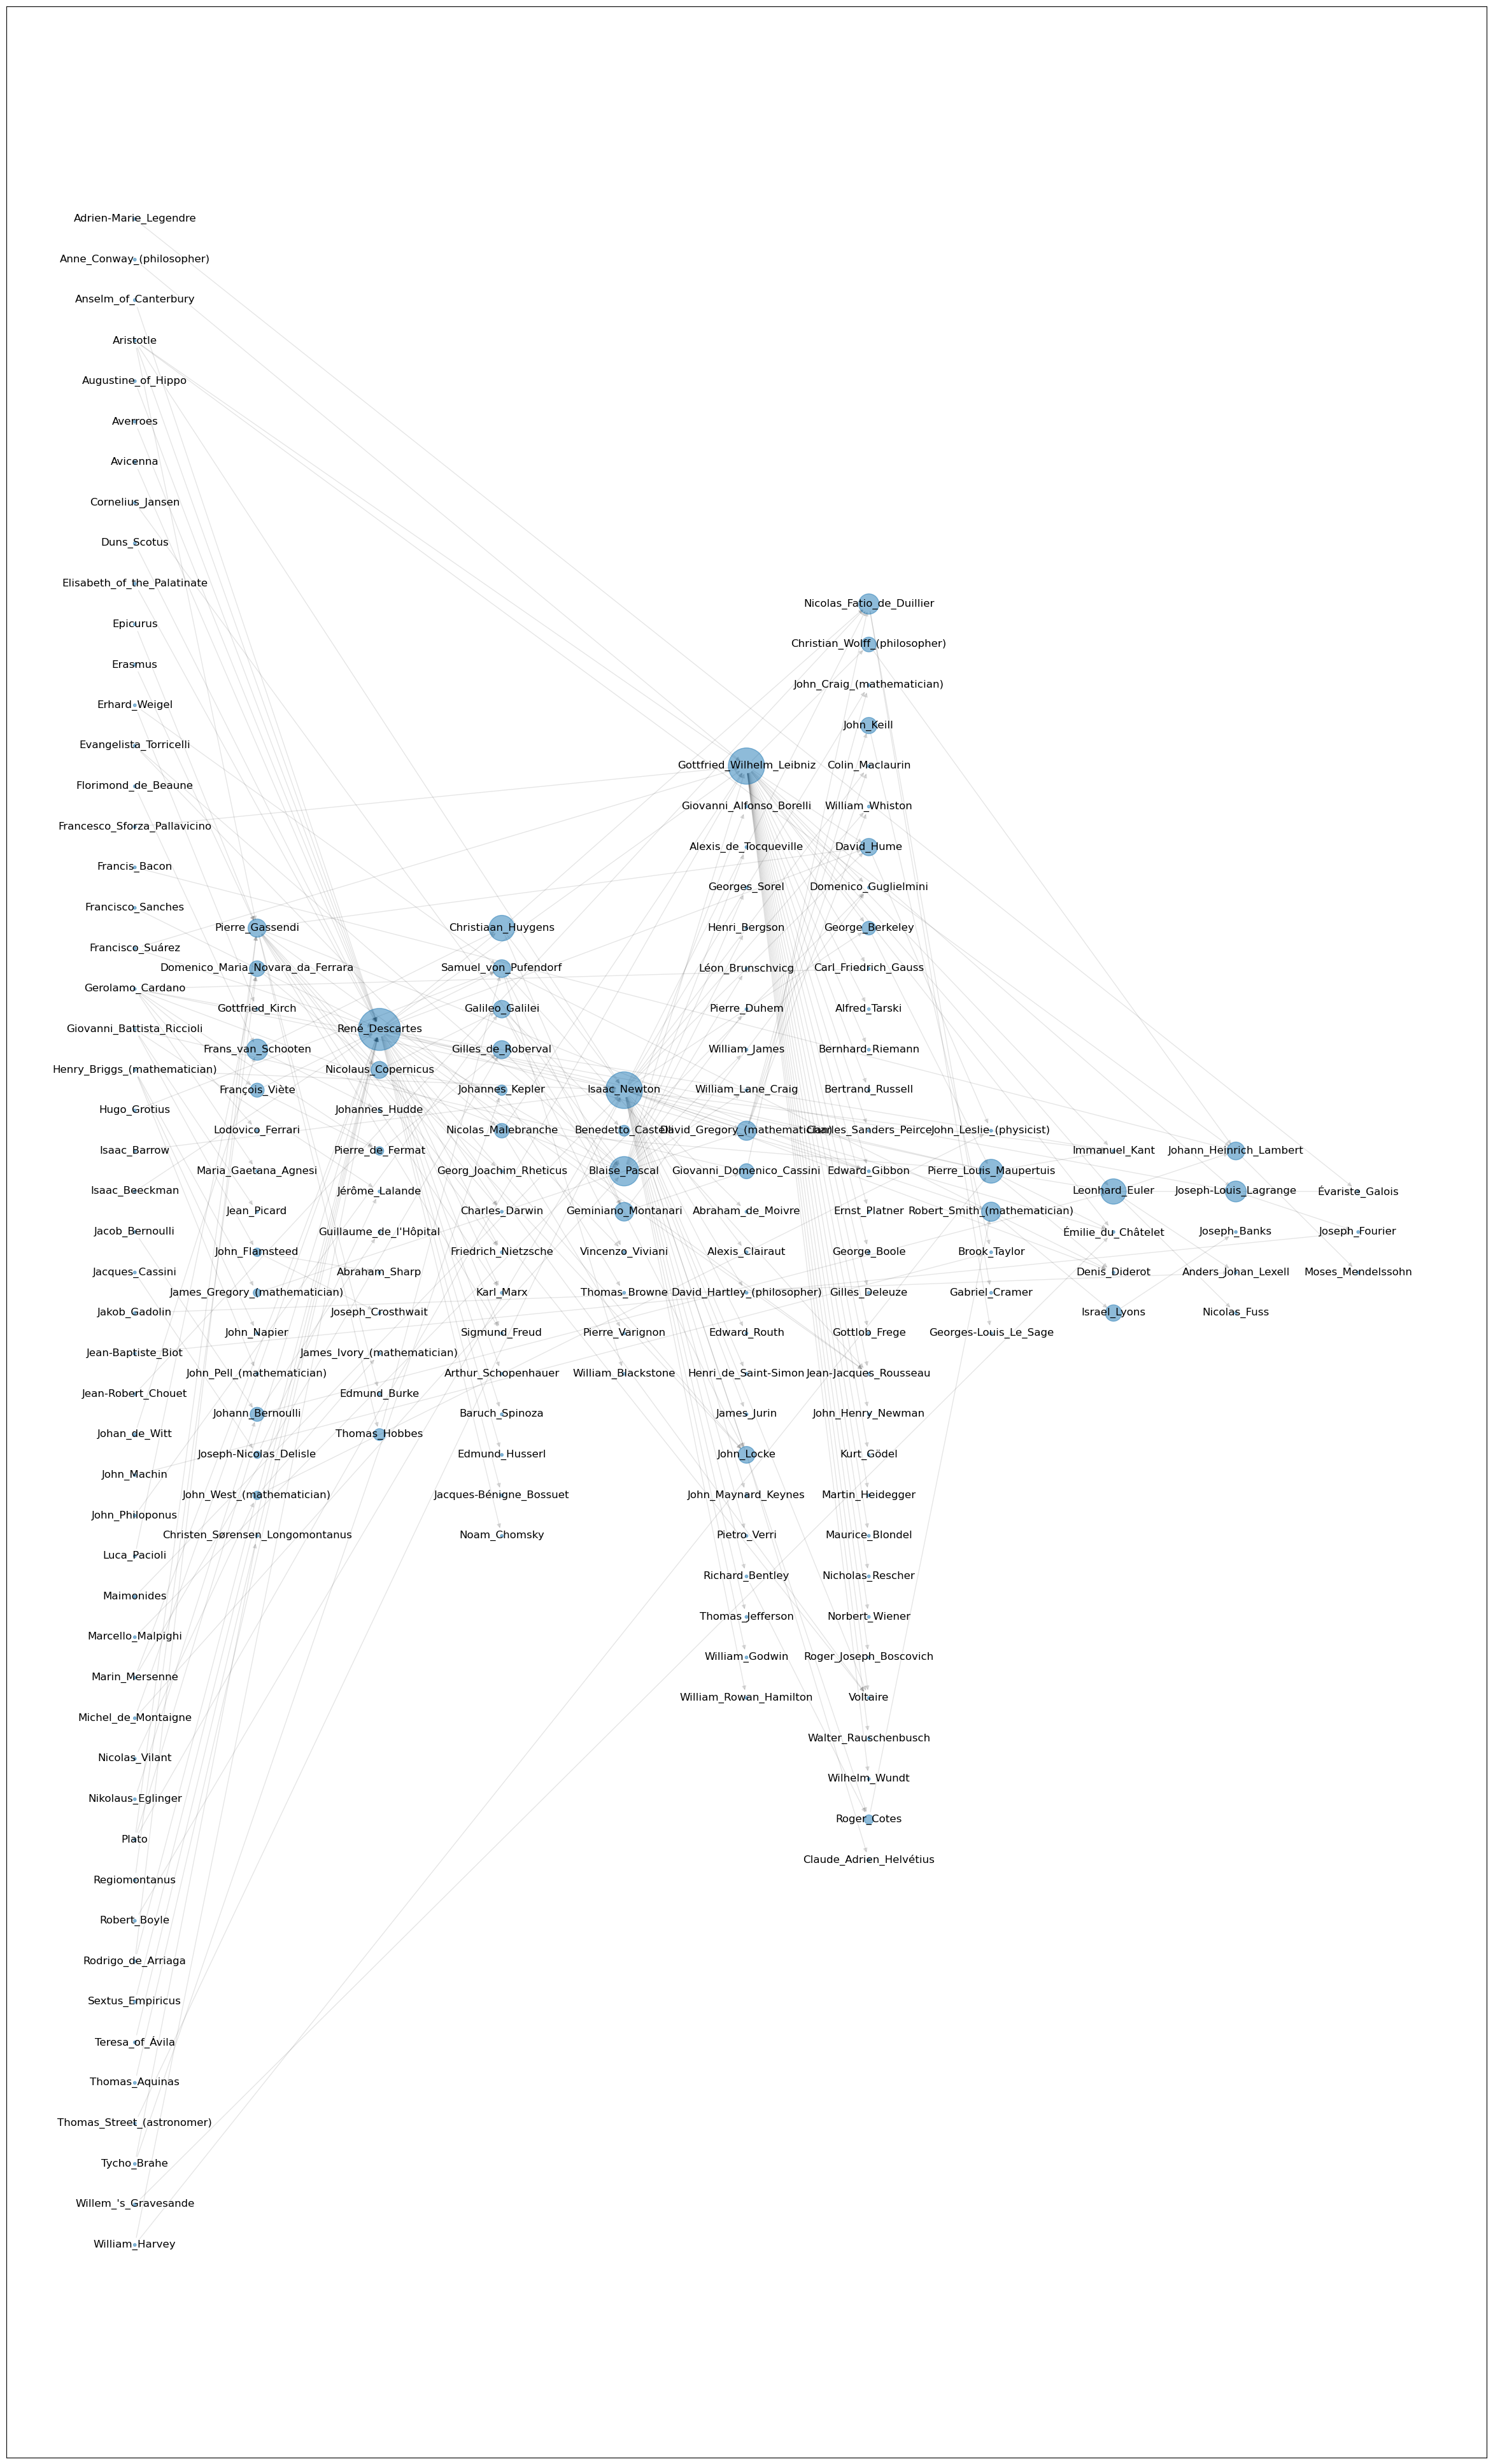

In [ ]:
pos = nx.multipartite_layout(SG, subset_key="layer")

plt.figure(figsize = (30,50))


nx.draw_networkx_nodes(SG,pos=pos,node_size=node_sizes, alpha=0.5)#draw nodes
nx.draw_networkx_labels(SG, pos,font_size=12)
[nx.draw_networkx_edges(SG,pos=pos,alpha=0.1)] #loop through edges and draw them

plt.show()

### Générations

In [ ]:
df.columns

Index(['subject_uri', 'subjectBirthDate', 'typeRelationship', 'object_uri',
       'objectBirthDate', 'source', 'relationship', 'target'],
      dtype='object')

In [ ]:
### Récupérer l'URI et date de naissance des sujets-sources
df1 = df[['subject_uri', 'subjectBirthDate']].copy(deep=True)
df1.columns=['uri','birthDate']
df1['object'] = df1['uri'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
len(df1),df1.head()

(336,
                                                  uri   birthDate  \
 0  http://dbpedia.org/resource/Domenico_Maria_Nov...  1454-08-01   
 1  http://dbpedia.org/resource/Domenico_Maria_Nov...  1454-08-01   
 2    http://dbpedia.org/resource/Nicolaus_Copernicus  1473-02-19   
 3    http://dbpedia.org/resource/Nicolaus_Copernicus  1473-02-19   
 4    http://dbpedia.org/resource/Nicolaus_Copernicus  1473-02-19   
 
                              object  
 0  Domenico_Maria_Novara_da_Ferrara  
 1  Domenico_Maria_Novara_da_Ferrara  
 2               Nicolaus_Copernicus  
 3               Nicolaus_Copernicus  
 4               Nicolaus_Copernicus  )

In [ ]:
### Récupérer l'URI et date de naissance des targets 
df2 = df[['object_uri', 'objectBirthDate']].copy(deep=True)
df2.columns=['uri','birthDate']
df2['object'] = df2['uri'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
len(df2), df2.head()

(336,
                                                  uri   birthDate  \
 0          http://dbpedia.org/resource/Regiomontanus  1436-06-06   
 1           http://dbpedia.org/resource/Luca_Pacioli        1447   
 2        http://dbpedia.org/resource/Johannes_Kepler  1571-12-27   
 3  http://dbpedia.org/resource/Domenico_Maria_Nov...  1454-08-01   
 4  http://dbpedia.org/resource/Domenico_Maria_Nov...  0001-07-29   
 
                              object  
 0                     Regiomontanus  
 1                      Luca_Pacioli  
 2                   Johannes_Kepler  
 3  Domenico_Maria_Novara_da_Ferrara  
 4  Domenico_Maria_Novara_da_Ferrara  )

In [ ]:
## Concaténer les deux tableaux
cdf = pd.concat([df1,df2])
len(cdf)

672

### Inspection et nettoyage des valeurs

In [ ]:
## supprimer les doublons afin d'avoir des valeurs uniques
cdf = cdf.drop_duplicates(); len(cdf)
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 0 to 333
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   uri        269 non-null    object
 1   birthDate  268 non-null    object
 2   object     269 non-null    object
dtypes: object(3)
memory usage: 8.4+ KB


In [ ]:
## On observe qu'il y a des valeurs nulles, les chercher
cdf[cdf.isna().any(axis=1)]

uri birthDate      object
58  http://dbpedia.org/resource/David_Hume       NaN  David_Hume

In [ ]:
## Y a-t- il d'autres lignes concernant Hume
cdf[cdf['object'].str.contains('Hume')]

uri   birthDate      object
57  http://dbpedia.org/resource/David_Hume  0001-05-07  David_Hume
58  http://dbpedia.org/resource/David_Hume         NaN  David_Hume

In [ ]:
## Supprimer la ligne à double
cdf = cdf.drop(index=58)

In [ ]:
cdf['birthDate'][cdf.index==57] = '1711-05-07'

In [ ]:
cdf.birthDate.sort_values(ascending=False).head(20)

37                c. 490
299              c. 1736
284              c. 1700
263              c. 1686
189              c. 1653
100           c. 1265/66
97               c. 1033
104    Second century AD
186         October 1630
32         November 1638
61       February 341 BC
178        February 1698
99                   980
64                   428
63                   384
130           1949-08-23
74            1928-12-07
205           1928-07-15
199           1925-01-18
212           1906-04-28
Name: birthDate, dtype: object

In [ ]:
cdf[cdf.index==37]

uri birthDate           object
37  http://dbpedia.org/resource/John_Philoponus    c. 490  John_Philoponus

In [ ]:
#### Corrections effectuéés
# Code 0002 = avant notre Ère
cdf['birthDate'][cdf.index==37] = '0490'
cdf['birthDate'][cdf.index==299] = '1736'
cdf['birthDate'][cdf.index==284] = '1700'
cdf['birthDate'][cdf.index==263] = '1686'
cdf['birthDate'][cdf.index==189] = '1653'
cdf['birthDate'][cdf.index==100] = '1265'
cdf['birthDate'][cdf.index==97] = '1033'
cdf['birthDate'][cdf.index==104] = '0002'
cdf['birthDate'][cdf.index==186] = '1630'
cdf['birthDate'][cdf.index==32] = '1638'
cdf['birthDate'][cdf.index==61] = '0002'
cdf['birthDate'][cdf.index==178] = '1698'
cdf['birthDate'][cdf.index==99] = '0980'
cdf['birthDate'][cdf.index==64] = '0428'
cdf['birthDate'][cdf.index==63] = '0384'

In [ ]:
cdf.birthDate.sort_values(ascending=True).head(20)

183    0001-03-28
184    0001-03-30
175    0001-06-21
4      0001-07-29
62     0001-10-28
15     0001-10-31
179    0001-12-15
14     0001-12-25
61           0002
104          0002
88     0354-11-13
63           0384
64           0428
37           0490
99           0980
97           1033
89     1126-04-14
87     1225-01-28
100          1265
0      1436-06-06
Name: birthDate, dtype: object

In [ ]:
cdf[cdf.birthDate.str.contains('0001')]

uri   birthDate  \
4    http://dbpedia.org/resource/Domenico_Maria_Nov...  0001-07-29   
14            http://dbpedia.org/resource/Isaac_Newton  0001-12-25   
15        http://dbpedia.org/resource/Pierre_de_Fermat  0001-10-31   
62                 http://dbpedia.org/resource/Erasmus  0001-10-28   
175  http://dbpedia.org/resource/David_Hartley_(phi...  0001-06-21   
179            http://dbpedia.org/resource/James_Jurin  0001-12-15   
183             http://dbpedia.org/resource/Maimonides  0001-03-28   
184             http://dbpedia.org/resource/Maimonides  0001-03-30   

                               object  
4    Domenico_Maria_Novara_da_Ferrara  
14                       Isaac_Newton  
15                   Pierre_de_Fermat  
62                            Erasmus  
175       David_Hartley_(philosopher)  
179                       James_Jurin  
183                        Maimonides  
184                        Maimonides

In [ ]:
## Supprimer la ligne à double
cdf = cdf.drop(index=[4,14,15, 62, 175, 179, 184])

In [ ]:
cdf[cdf.object.str.contains('Newton')]

uri   birthDate        object
156  http://dbpedia.org/resource/Isaac_Newton  1642-12-25  Isaac_Newton

In [ ]:
cdf['year'] = cdf['birthDate'].apply(lambda x : int(str(x)[:4]))
cdf.head(3)

uri   birthDate  \
0  http://dbpedia.org/resource/Domenico_Maria_Nov...  1454-08-01   
2    http://dbpedia.org/resource/Nicolaus_Copernicus  1473-02-19   
5        http://dbpedia.org/resource/Nicolaus_Olahus  1493-01-10   

                             object  year  
0  Domenico_Maria_Novara_da_Ferrara  1454  
2               Nicolaus_Copernicus  1473  
5                   Nicolaus_Olahus  1493

In [ ]:
cdf.year.sort_values(ascending=True).head(20)

183       1
61        2
104       2
88      354
63      384
64      428
37      490
99      980
97     1033
89     1126
87     1225
100    1265
0      1436
1      1447
0      1454
60     1466
17     1469
2      1473
6      1482
5      1493
Name: year, dtype: int64

<Axes: >

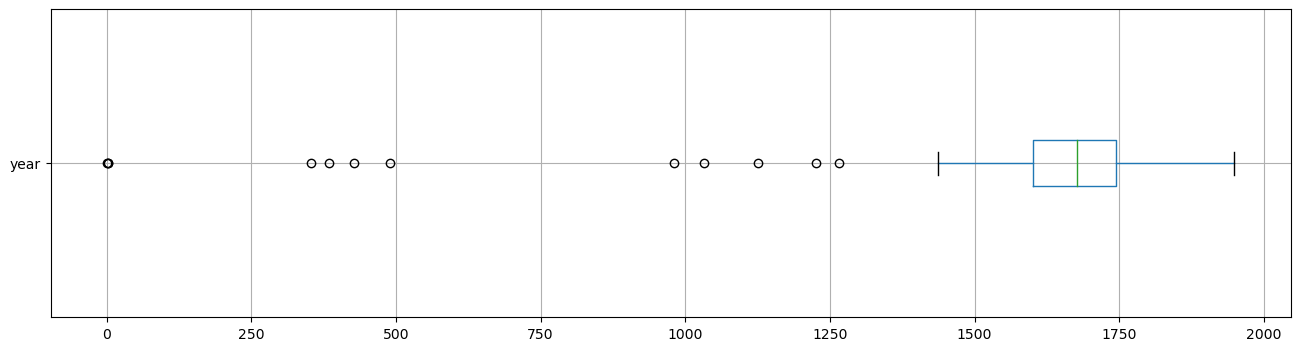

In [ ]:
cdf.boxplot(column=['year'], vert=False, figsize=(16,4))

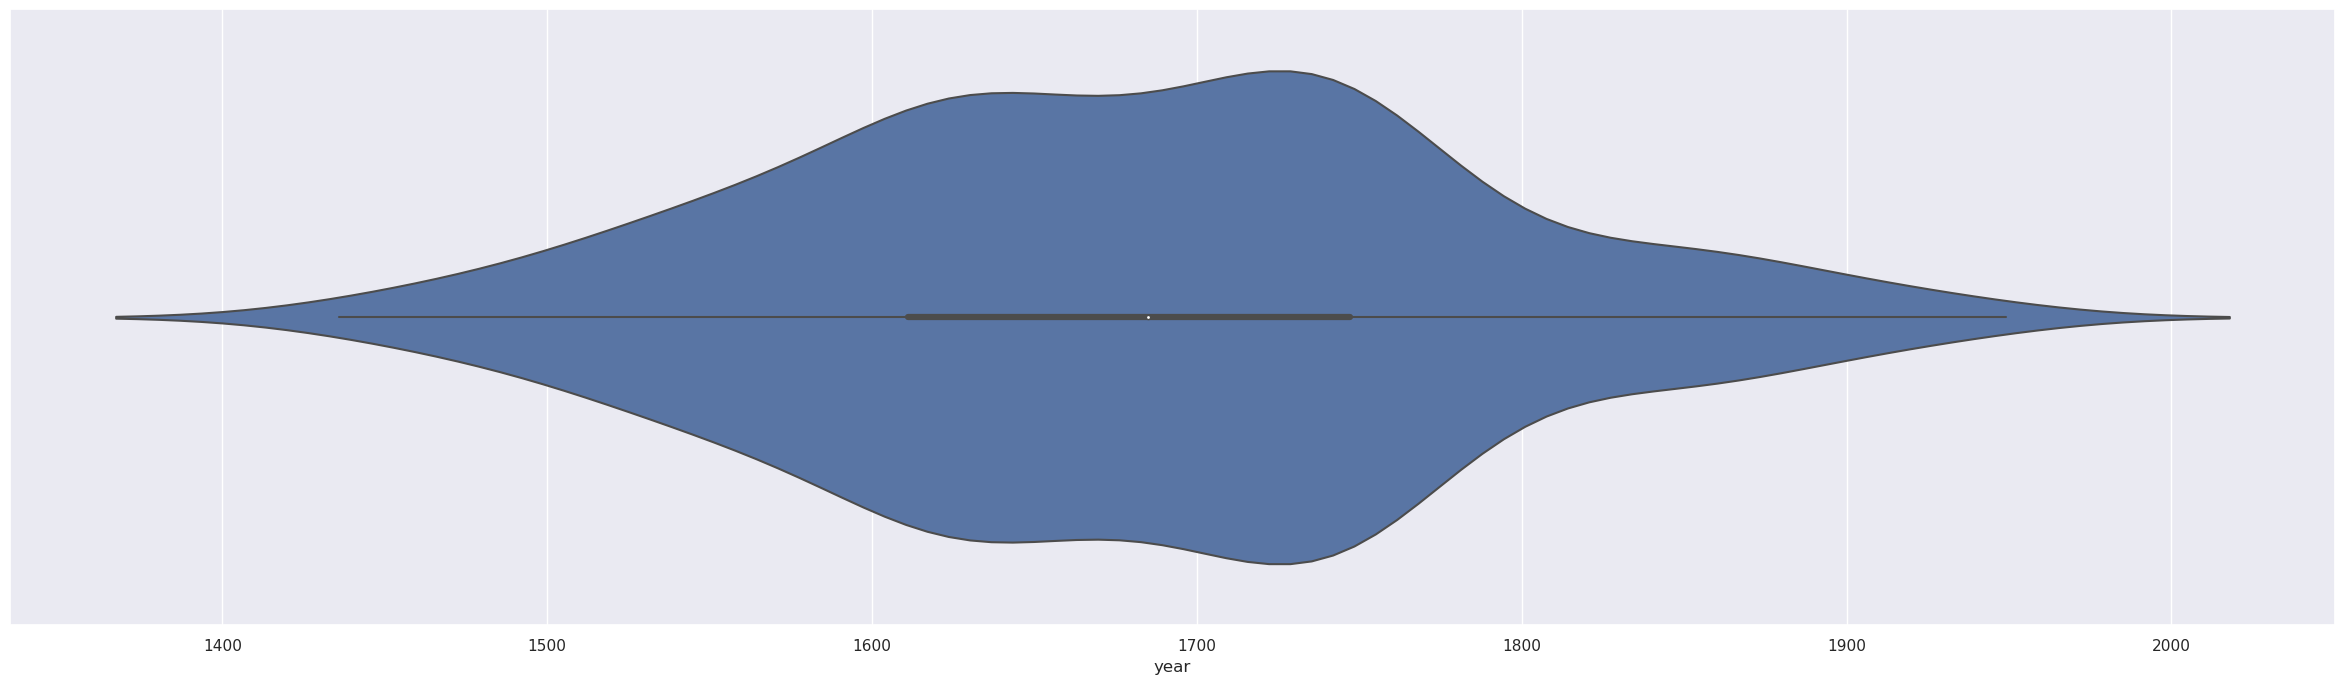

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(30, 8)})

ax = sns.violinplot(x='year', 
                    data = cdf[cdf['year']>1300])


In [ ]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 333
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   uri        261 non-null    object
 1   birthDate  261 non-null    object
 2   object     261 non-null    object
 3   year       261 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.2+ KB


In [ ]:
bins = [r for r in range(1421, 1821, 20)]
bins = [0] + bins + [2001]
bins

[0,
 1421,
 1441,
 1461,
 1481,
 1501,
 1521,
 1541,
 1561,
 1581,
 1601,
 1621,
 1641,
 1661,
 1681,
 1701,
 1721,
 1741,
 1761,
 1781,
 1801,
 2001]

In [ ]:
cdf['cut_year'] = pd.cut(cdf['year'], bins=bins, right=False  )
cdf.head(2)

uri   birthDate  \
0  http://dbpedia.org/resource/Domenico_Maria_Nov...  1454-08-01   
2    http://dbpedia.org/resource/Nicolaus_Copernicus  1473-02-19   

                             object  year      cut_year  
0  Domenico_Maria_Novara_da_Ferrara  1454  [1441, 1461)  
2               Nicolaus_Copernicus  1473  [1461, 1481)

In [ ]:
ccc = pd.DataFrame(cdf.groupby(by='cut_year').size())
ccc = ccc.reset_index()
ccc['gen'] = ccc.index
ccc.columns=['cut_year', 'eff', 'gen']
ccc

cut_year  eff  gen
0      [0, 1421)   12    0
1   [1421, 1441)    1    1
2   [1441, 1461)    2    2
3   [1461, 1481)    3    3
4   [1481, 1501)    2    4
5   [1501, 1521)    7    5
6   [1521, 1541)    8    6
7   [1541, 1561)    9    7
8   [1561, 1581)   10    8
9   [1581, 1601)   11    9
10  [1601, 1621)   16   10
11  [1621, 1641)   25   11
12  [1641, 1661)   14   12
13  [1661, 1681)   13   13
14  [1681, 1701)   18   14
15  [1701, 1721)   16   15
16  [1721, 1741)   24   16
17  [1741, 1761)   25   17
18  [1761, 1781)   11   18
19  [1781, 1801)    2   19
20  [1801, 2001)   32   20

<Axes: xlabel='cut_year'>

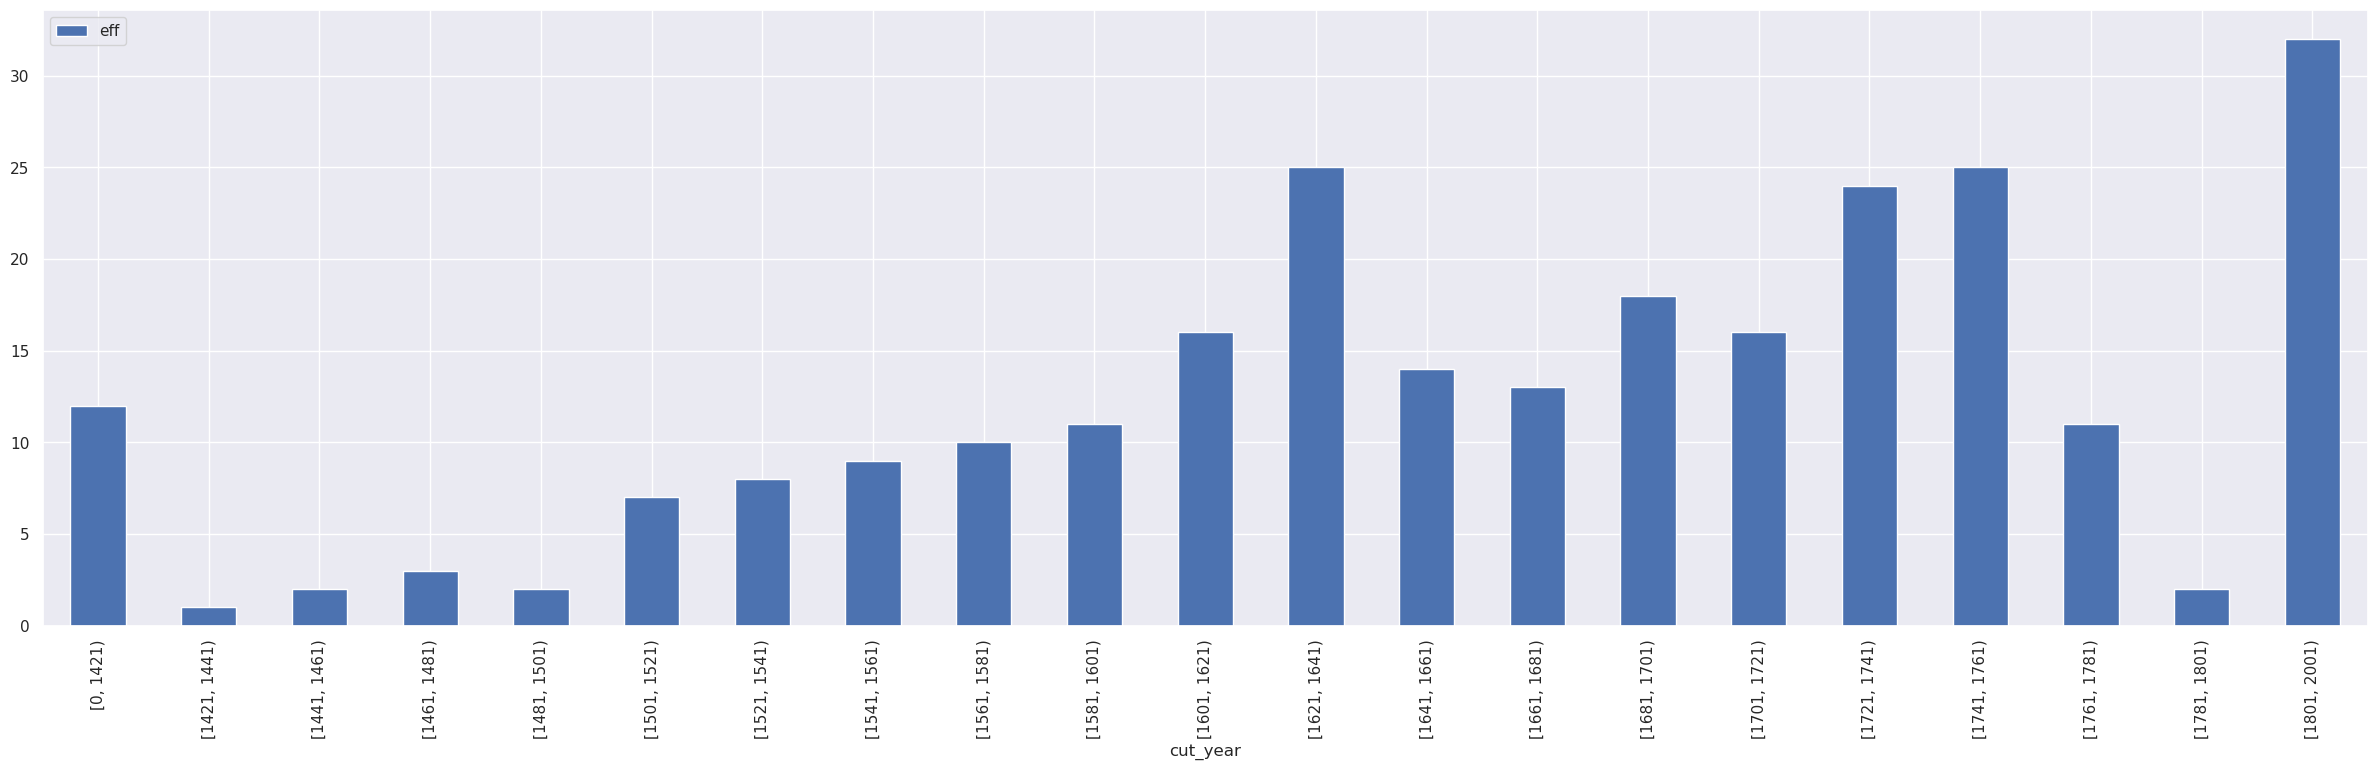

In [ ]:
ccc.plot.bar(x = "cut_year", y = "eff")

In [ ]:
ccc = ccc.drop('eff', axis=1)
type(ccc), ccc

(pandas.core.frame.DataFrame,
         cut_year  gen
 0      [0, 1421)    0
 1   [1421, 1441)    1
 2   [1441, 1461)    2
 3   [1461, 1481)    3
 4   [1481, 1501)    4
 5   [1501, 1521)    5
 6   [1521, 1541)    6
 7   [1541, 1561)    7
 8   [1561, 1581)    8
 9   [1581, 1601)    9
 10  [1601, 1621)   10
 11  [1621, 1641)   11
 12  [1641, 1661)   12
 13  [1661, 1681)   13
 14  [1681, 1701)   14
 15  [1701, 1721)   15
 16  [1721, 1741)   16
 17  [1741, 1761)   17
 18  [1761, 1781)   18
 19  [1781, 1801)   19
 20  [1801, 2001)   20)

In [ ]:
mmm = pd.merge(cdf, ccc, left_on='cut_year', right_on='cut_year')
### https://github.com/mwouts/itables/blob/main/docs/advanced_parameters.md
show(mmm.sort_values(by='cut_year'), classes="display", scrollY="300px", scrollCollapse=True, paging=False, column_filters="footer", dom="lrtip")

In [ ]:
### Vérifier que les classes sont bie nuniques
mmm.groupby(by='object').size().sort_values(ascending=False).head(10)

object
Abraham_Gotthelf_Kästner      1
Jérôme_Lalande                1
Karl_Marx                     1
Kurt_Gödel                    1
Laurentius_Paulinus_Gothus    1
Lazare_Carnot                 1
Leonhard_Euler                1
Lodovico_Ferrari              1
Louis-Alexandre_Berthier      1
Luca_Pacioli                  1
dtype: int64

## Plot par génération

In [ ]:
mmm_d = dict([(g[0],  g[1]) for g in mmm[['object', 'gen']].values])
list(mmm_d.items())[:3]

[('Domenico_Maria_Novara_da_Ferrara', 2),
 ('Luca_Pacioli', 2),
 ('Nicolaus_Copernicus', 3)]

In [ ]:
nx.set_node_attributes(SG, mmm_d, 'gen')
print(list(SG.nodes.data())[:3])

[('Adrien-Marie_Legendre', {'degree': 1, 'eigenvector': 2.1928007626693484e-16, 'betweenness': 0.0, 'layer': 0, 'gen': 17}), ('Évariste_Galois', {'degree': 2, 'eigenvector': 4.444092967190851e-19, 'betweenness': 0.0, 'layer': 10, 'gen': 20}), ('Anne_Conway_(philosopher)', {'degree': 1, 'eigenvector': 3.2274346352832955e-07, 'betweenness': 0.0, 'layer': 0, 'gen': 11})]


In [ ]:
### Vérifier que toutes les valeurs sont renseignées
print([(i[0],i[1].get('gen')) for i in SG.nodes.data() if i[1].get('gen') == None])

[]


### Valeurs de centralité

Observer la différence dans la représentation graphique entre les centralité d'intermédiarité et de pouvoir 

In [ ]:
### Souligne qui est en position d'intermédiaire entre les générations 
# Définit la taille des attribut à l'affichage
node_sizes_b = [np.sqrt(i[1]['betweenness'])*20000 + 10 for i in list(SG.nodes.data())]
node_sizes_b[:3]

[10.0, 10.0, 10.0]

In [ ]:
d = nx.get_node_attributes(SG, 'betweenness')
sorted(d.items(), key=lambda x:x[1], reverse=True)[:10]

[('René_Descartes', 0.050850649350649355),
 ('Isaac_Newton', 0.02941558441558441),
 ('Gottfried_Wilhelm_Leibniz', 0.028095779220779216),
 ('Blaise_Pascal', 0.011987554112554113),
 ('Christiaan_Huygens', 0.006866883116883117),
 ('Leonhard_Euler', 0.006570346320346321),
 ('Pierre_Louis_Maupertuis', 0.005178030303030304),
 ('Frans_van_Schooten', 0.003181818181818182),
 ('Joseph-Louis_Lagrange', 0.002987012987012987),
 ('Nicolas_Fatio_de_Duillier', 0.0026623376623376624)]

In [ ]:
### Souligne qui est à l'origine de la plus grande déscendance
# Définit la taille des attribut à l'affichage
node_sizes_e = [np.sqrt(i[1]['eigenvector'])*20000 + 10 for i in list(SG.nodes.data())]
node_sizes_e[:3]

[10.00029616216927, 10.000013332806107, 21.362103036468724]

In [ ]:
d = nx.get_node_attributes(SG, 'eigenvector')
sorted(d.items(), key=lambda x:x[1], reverse=True)[:10]

[('Gerolamo_Cardano', 0.9995402580185031),
 ('François_Viète', 0.028271343068396165),
 ('Marin_Mersenne', 0.003196761702619798),
 ('Michel_de_Montaigne', 0.002523575315420364),
 ('Aristotle', 0.002507963873816927),
 ('Francisco_Suárez', 0.002507461797440412),
 ('Plato', 0.002507461683908996),
 ('Elisabeth_of_the_Palatinate', 0.002507139053976346),
 ('Augustine_of_Hippo', 0.0025071390539763167),
 ('Averroes', 0.002507139053976242)]

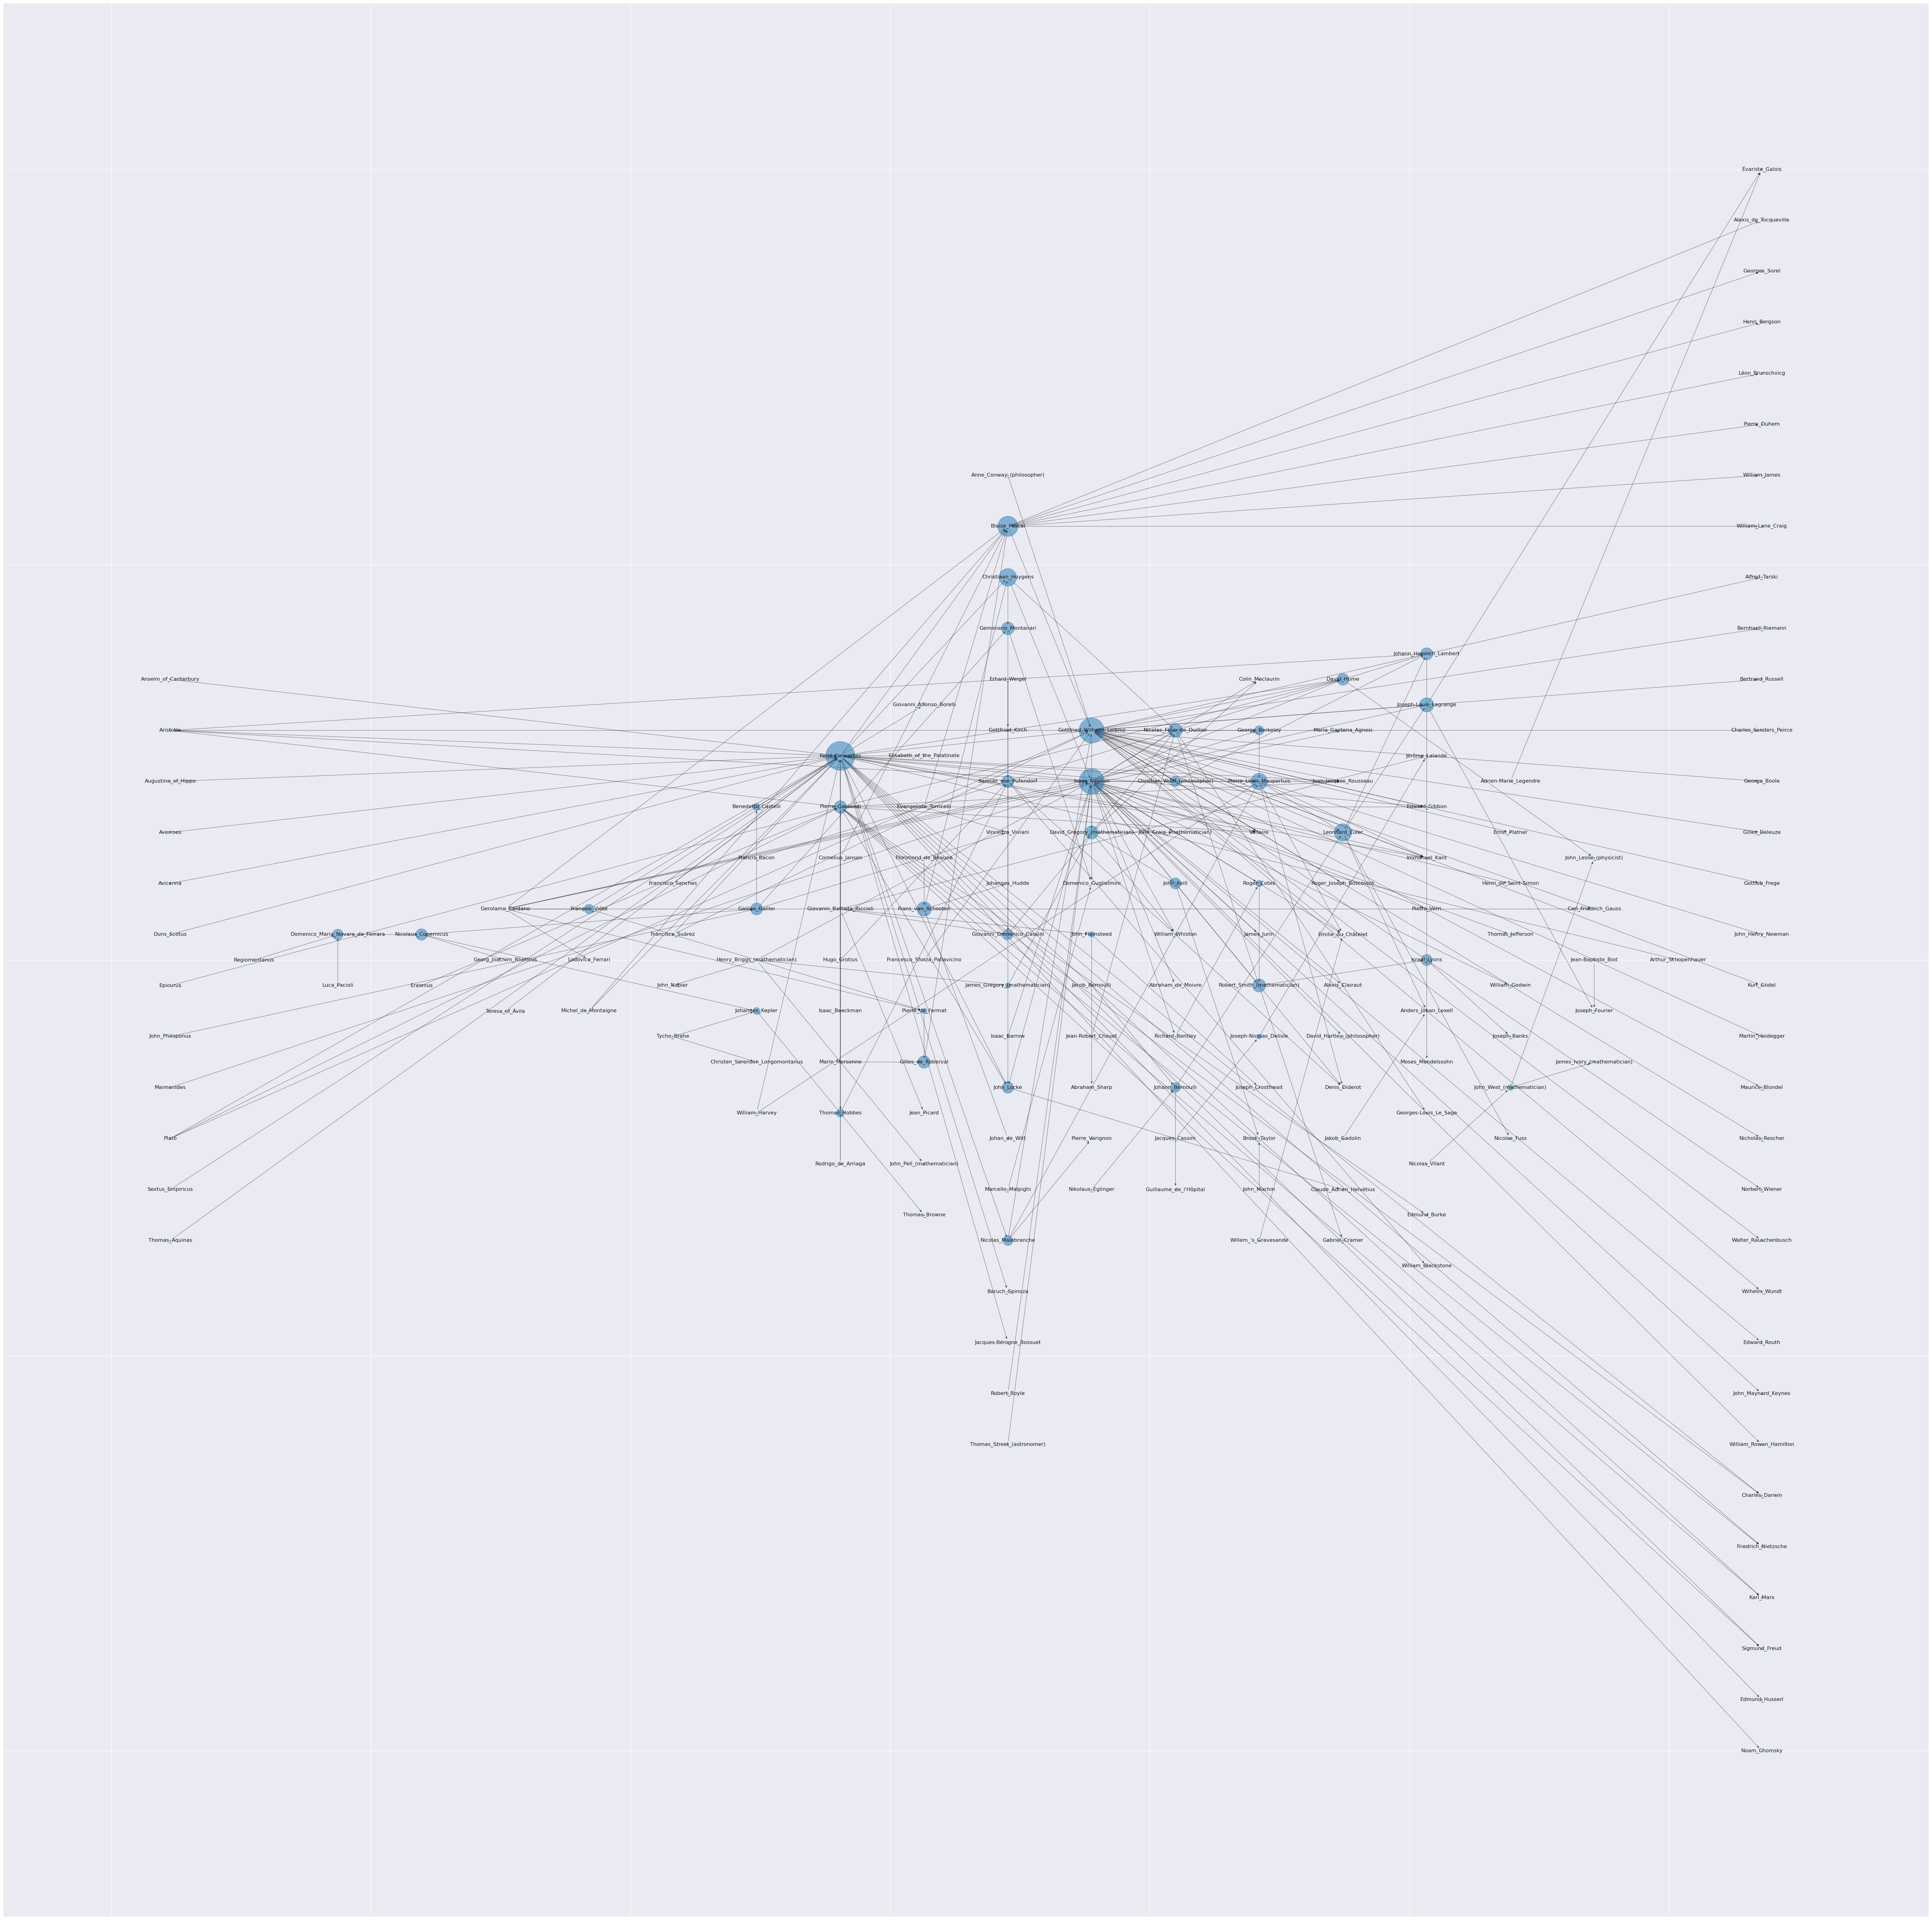

In [ ]:
pos = nx.multipartite_layout(SG, subset_key="gen")

plt.figure(figsize = (80,80))

## Alternet et inspecter node size : node_sizes_b ou node_sizes_e
nx.draw_networkx_nodes(SG,pos=pos,node_size=node_sizes_b, alpha=0.5)#draw nodes
nx.draw_networkx_labels(SG,pos=pos, font_size=12)
[nx.draw_networkx_edges(SG,pos=pos,alpha=0.5)] #loop through edges and draw them

f = 'pictures/filiations.svg'# io.BytesIO()

plt.savefig(f, format="svg")

plt.show()

## Créer un ego-graphe

Dans l'ego-graphe on choisit un sommet et on calcule toutes ses relations, ascendantes et déscendantes

In [ ]:
def draw_ego_graph(graph, person, radius=2, center=True, undirected=False, distance=None, centrality = 'betweenness', centrality_factor= 10000):
    
    
    EG = nx.ego_graph(graph, person, radius=radius, center=center, undirected=undirected, distance=distance)

    ### Adapter la taille des attribut à l'affichage
    node_sizes = [np.sqrt(i[1][centrality]) * centrality_factor + 10 for i in list(EG.nodes.data())]


    pos = nx.multipartite_layout(SG, subset_key="gen")

    plt.figure(figsize = (30,15))
    
    nodes_cols = ['red' if i == person else 'blue' for i in EG.nodes]


    nx.draw_networkx_nodes(EG,pos=pos,node_size=node_sizes, node_color=nodes_cols, alpha=0.6)
    nx.draw_networkx_labels(EG,pos=pos, font_size=12)
    [nx.draw_networkx_edges(EG,pos=pos,alpha=0.5)] #loop through edges and draw them

    f = f'pictures/ego_graph_{person}_r{str(radius)}.svg'# io.BytesIO()

    plt.savefig(f, format="svg")

    plt.show()
    
    return EG

In [ ]:
## Exemples : Johannes_Kepler Galileo_Galilei Geminiano_Montanari Leonhard_Euler

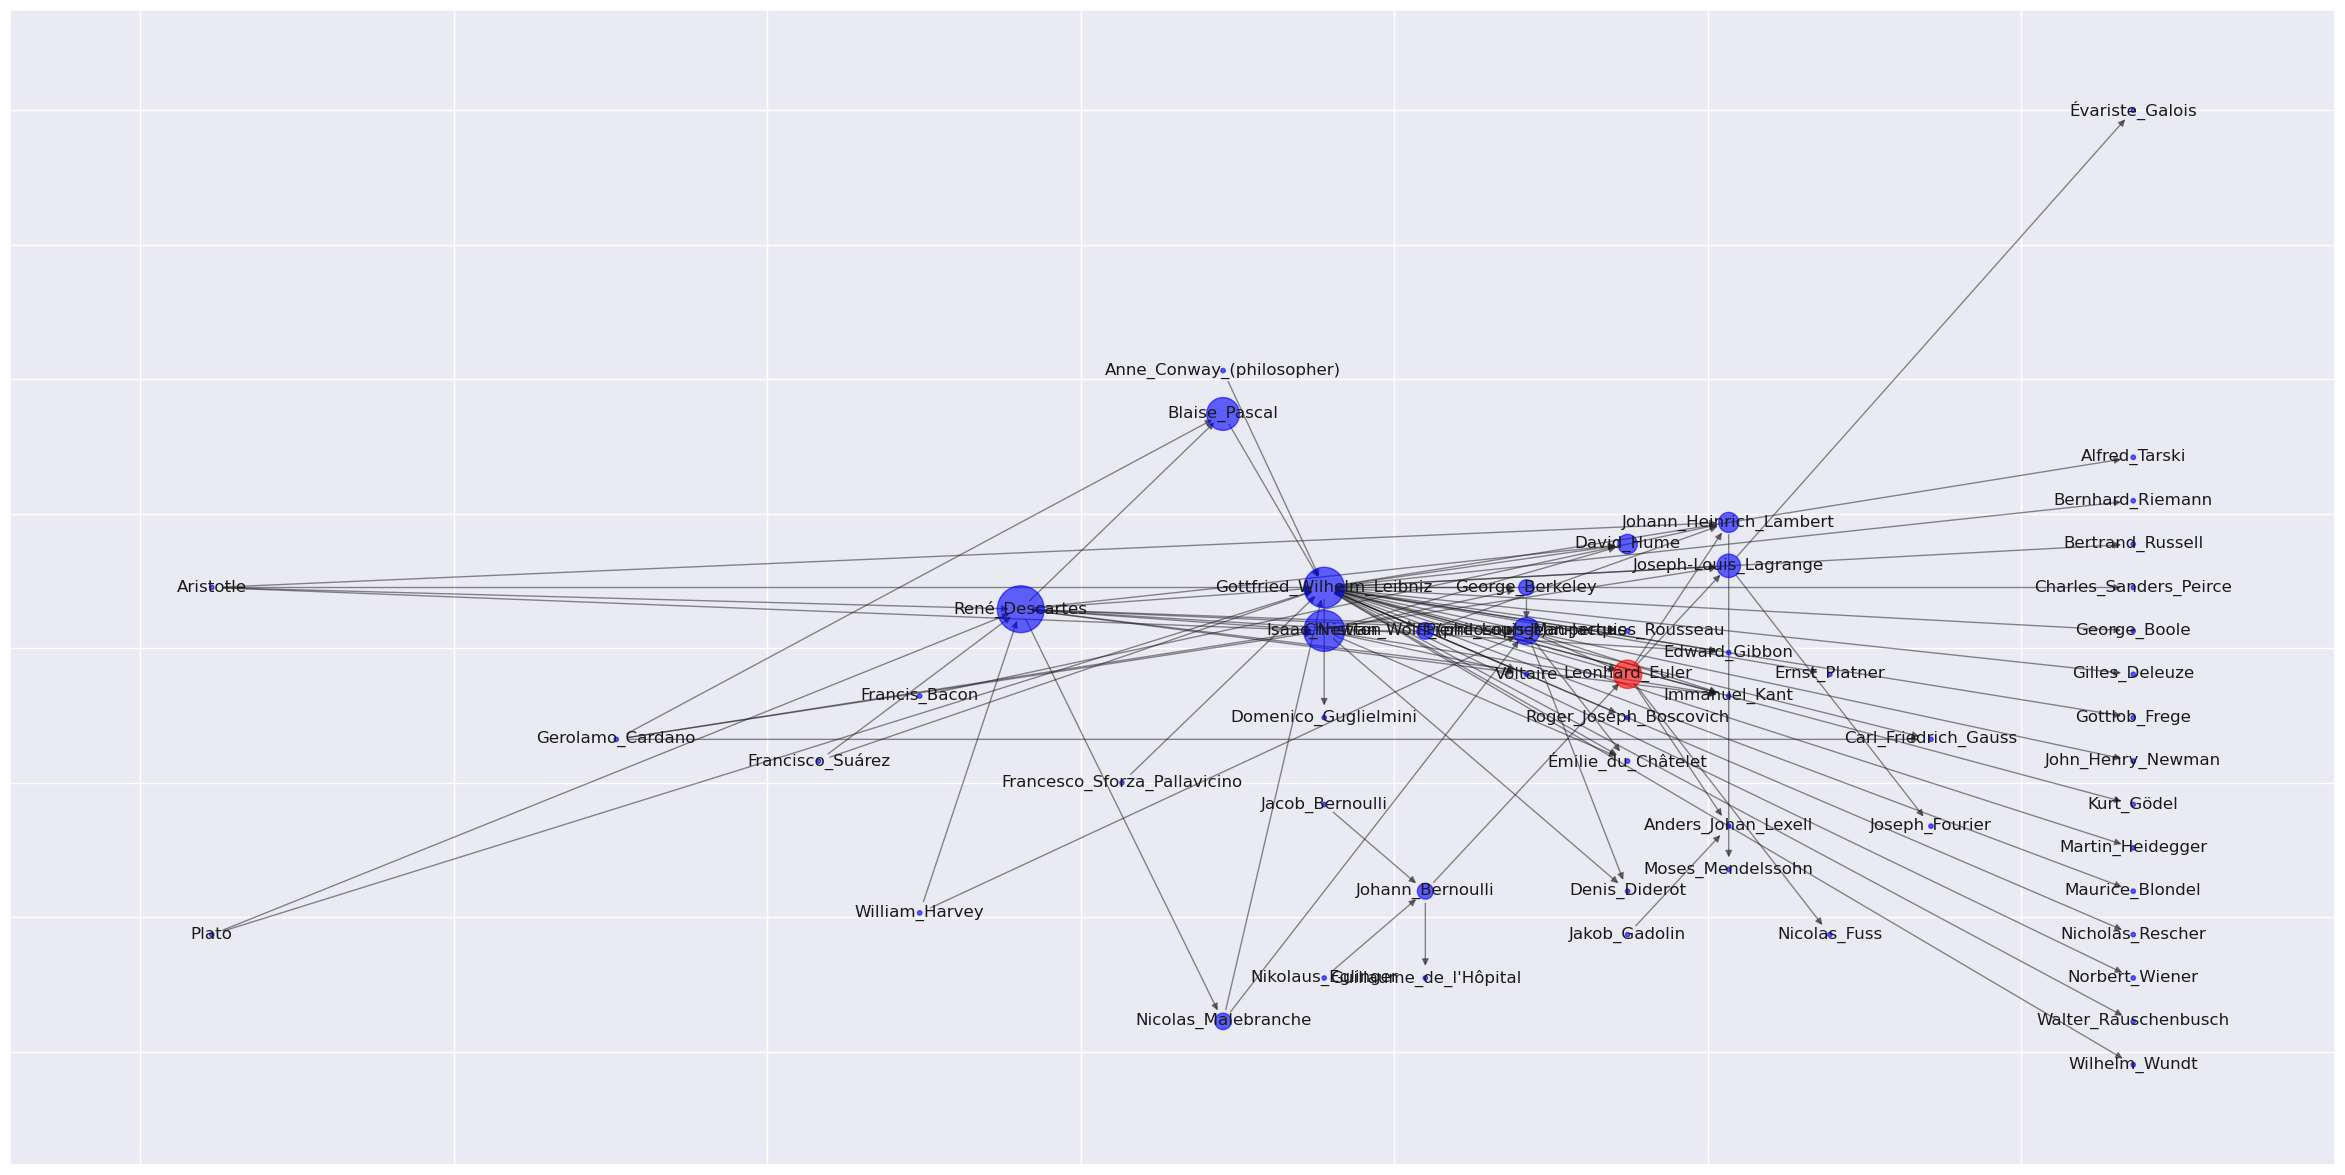

In [ ]:
### Adapter les types de centralité ou le rayon des personnes considérées
eg = draw_ego_graph(SG, 'Leonhard_Euler', radius=2, center=True, undirected=True, distance=None, centrality = 'betweenness', centrality_factor= 5000 )

In [ ]:
### On peut récupérer et utiliser pour d'autres analyses le contenu de l'ego-graph
list(eg.nodes.data())[:3]

[('Plato',
  {'degree': 3,
   'eigenvector': 0.002507461683908996,
   'betweenness': 0.0,
   'layer': 0,
   'gen': 0}),
 ('Johann_Heinrich_Lambert',
  {'degree': 5,
   'eigenvector': -1.1152900849559413e-14,
   'betweenness': 0.0015584415584415584,
   'layer': 9,
   'gen': 16}),
 ('Joseph-Louis_Lagrange',
  {'degree': 5,
   'eigenvector': -3.769401319241324e-15,
   'betweenness': 0.002987012987012987,
   'layer': 9,
   'gen': 16})]